# SYDE 552 Assignment 2: Vision
### Due Monday, February 19, 11:59pm
### Value: 15% of total marks for the course

This assignment covers the mammilian vision system, including both questions about the biology itself and constructing computational models based on Regression and Convolutional Neural Networks.

You can work in groups to do the assignment, but your answers and code must be original to you. Your submission will be a filled-out copy of this notebook (cells for code and written answers provided).

# 1. The Vision System

The purpose of this part of the assignment is to test your knowledge of the brain’s visual system and the relationship between neurobiological features and computational properties. The best answers will discuss both function and anatomy, and will draw on specific anatomical examples to support theoretical claims. You are encouraged to discuss answers with your classmates, consult the slides notes, or use external resources -- but your answers must be your own! In particular, read the Kandel et al. chapters listed on the slides. Expect to write around 5 sentences for each 1 point.

**1.a) [2 marks]** The neurons in different parts of the brain are sensitive to different things, and can be thought of as different feature detectors.  For each of the types of neurons listed below, describe what feature they detect, their receptive fields, and how their connectivity to other neurons and/or their internal neural processes helps them to do this feature detection:
- Cones
  - These are the primary receptors. The frequency of their spikes correlate with the intensity of light, due to phototransduction. There are different cones that are more sensitive to different frequencies of light. Their receptive field is simply whatever light interacts with them; in the eye this means they are sensitive to a dot in the perceptive field. They are the input to the rest of the visual system. 
- Sustained Ganglion Cells
  - Ganglion cells are downstream from cones. They occur have a series of horizontal, bipolar, and acramine cells. This results in lateral inhibition; ganglion cells have center-surround receptive fields. Light at the center of a ganglion cell will stimulate (or depress) its spiking, and light off-center will depress (or stimulate) it. The rest of the visual system uses ganglion cells as their input. Sustained ganglion cells have a slower time constant, meaning that they will continue to have an altered firing rate in the prescence of a stimulus.
- Transient Ganglion Cells
  - Transient ganglion cells differ from sustained ganglion cells in that they have a fast time constant. This means that their response will be altered due to an initial change in stimulus, but will quickly decay to the baseline firing rate. This is useful for detecting changes in the perceptive field. 
- Simple Cells
  - Simple cells exist in V1, downstream of ganglion cells and the LGN. At this point, the input from both eyes have been combined. Simple cells combine the receptive fields of ganglion cells, creating sensitivity to lines at different angles. Sequences of these simple cells with similar orientations give us sensitivity to different spatial frequencies. These cells differ from the previous cells because the connections are learned from a young age, and aren't "pre-wired."

**1. b) [1 marks]** Describe two instances where retinotopic organization facilitates visual processing.  For each example, be sure to mention its anatomical location and discuss how retinitopy contributes to the feature detection.

## TODO

**1. c) [2 marks]** Discuss the similarities and differences between convolutional neural networks and the visual system.

TODO

# 2. Classifying Stimuli Using Regression

The retina transforms the light entering an eye into a particular set of features, which are then sent to the rest of the brain for further processing.  In this section we look at how neurons might detect patterns, and how that detection changes with different feature detectors.

The data we will use for this is the classic MNIST dataset 

In [1]:
import torchvision
mnist = torchvision.datasets.MNIST(root='.', download=True)

The MNIST digits are 28x28 pixels each, each pixel is a value from 0 to 255, and there are 60,000 of them.  The raw data is in `mnist.data` and the target value (i.e. the actual digit) is in `mnist.targets`.  Here are the first 24 of each:

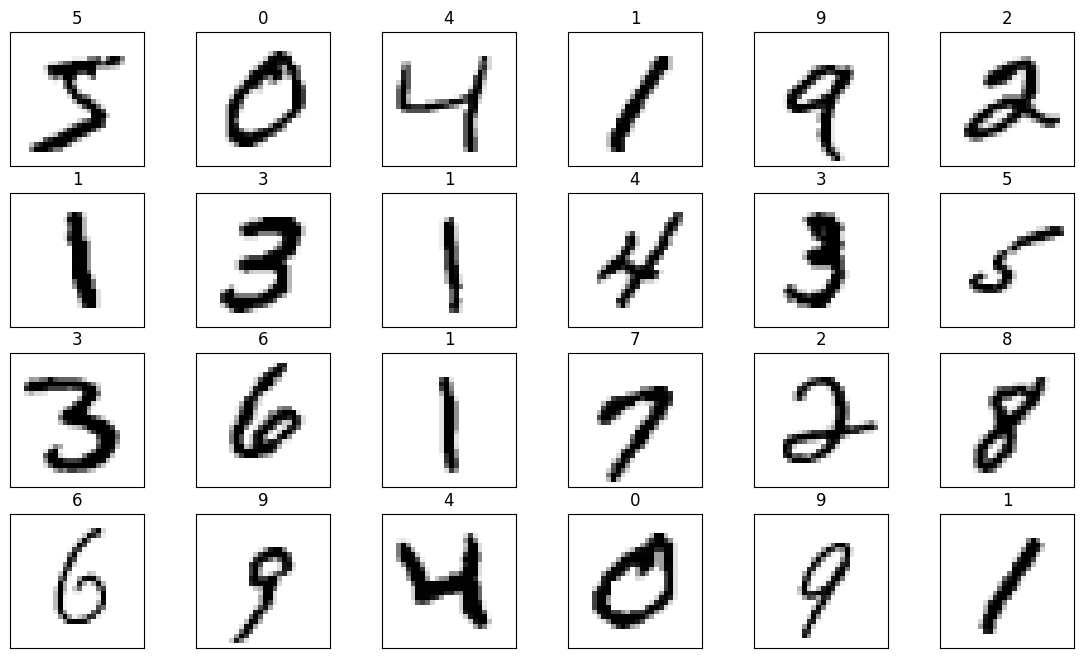

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(14,8))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(mnist.data[i], vmin=0, vmax=255, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title(int(mnist.targets[i]))

**2.a) [1 mark]** We can imagine the MNIST digits as 784 (28 times 28) input neurons.  We want to connect these 784 neurons to 10 output neurons, one for each digit, and see how accurately we can classify the digits.  

To find the weights in this question, we will use Ridge Regression.  `X` is the MNIST input data, divided by 255 to rescale it to between 0 and 1, and then reshaped to be a 60000x784 matrix

```
X = mnist.data.reshape((60000,28*28)).float()/255
```

The target data T is a "one-hot" representation of our outputs.  That is, instead of the desired output to be `5`, the output should be `[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]` and if the desired output should be `0`, that would be `[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]`.  

```
T = torch.nn.functional.one_hot(mnist.targets).float()
```

If our output is `Y=X @ W`, we need to find `W` such that `Y` is as close as possible to `T`.  For Ridge Regression, this is computed as

```
W = torch.inverse(X.T @ X + lambd*I) @ (X.T @ T)
```

where `I` is an identity matrix of the correct size (`torch.eye(784).float()`) and `lambd` is the $\lambda$ parameter that stops the regression from overfitting.

When building any sort of classifier model, we generally want to create the model using one set of data, and then test it on another set of data.  Here, we will use the first 5,000 data points for creating ("training") the model, and the other 55,000 for testing:

```
N = 5000
X_train, X_test = X[:N], X[N:]  # split X into two parts for training and testing
T_train, T_test = T[:N], T[N:]  # split T into two parts for training and testing
```

Given this data, you should find `W` using *only* the `X_train` and `T_train` data.  Once you find `W` you can apply it to the `X_train` and `X_test` to get `Y_train` and `Y_test`

```
Y_train = X_train @ W
Y_test = X_test @ W
```

Finally, you can compute the accuracy by determining when the output is the correct category.  Here we will do this by counting when the largest output value in each row in `Y` is at the same spot as the largest output value in each row in `T`:

```
accuracy_train = torch.sum(torch.argmax(Y_train, axis=1)==torch.argmax(T_train, axis=1))/len(Y_train)
accuracy_test = torch.sum(torch.argmax(Y_test, axis=1)==torch.argmax(T_test, axis=1))/len(Y_test)
```

- Compute the training and testing accuracy when $\lambda=1$ and we use the first 5,000 data points as for training (and test on the remaining 55,000).  Report both numbers.  
- Do we expect the testing accuracy to be larger or smaller than the training accuracy?  Why?
  - We should expect that the testing accuracy is smaller than the training accuracy. This is because the model is able to fit to the training dataset. For example, if the model overfitted the training data, it should perform very well on the training accuracy, but horribly interpolate/extrapolate, resulting in a poor testing accuracy. If there's minimal overfitting and the model generalizes well, the test accuracy should be just a little below the training accuracy

In [3]:
import torch
torch.manual_seed(0)  # for reproducibility

def test_ridge_regression(X, T, lambd: float, N: int = 5000):
    identity = torch.eye(28*28).float()
    inp = X.T @ X + lambd*identity
    W = torch.inverse(inp) @ (X.T @ T)
    X_train, X_test = X[:N], X[N:]  # split X into two parts for training and testing
    T_train, T_test = T[:N], T[N:]  # split T into two parts for training and testing
    Y_train = X_train @ W
    Y_test = X_test @ W
    accuracy_train = torch.sum(torch.argmax(Y_train, axis=1)==torch.argmax(T_train, axis=1))/len(Y_train)
    accuracy_test = torch.sum(torch.argmax(Y_test, axis=1)==torch.argmax(T_test, axis=1))/len(Y_test)
    return accuracy_train,accuracy_test

X = mnist.data.reshape((60000,28*28)).float()/255
T = torch.nn.functional.one_hot(mnist.targets).float()
accuracy_train, accuracy_test = test_ridge_regression(X, T, lambd=1)
print(f'Training accuracy: {accuracy_train:.3f}')
print(f'Testing accuracy: {accuracy_test:.3f}')

Training accuracy: 0.863
Testing accuracy: 0.851


**2. b) [2 marks]**  Repeat part a) but vary the value of `lambd` from $10^{-5}$ to $10^5$.   You can use a `for` loop such as `for lambd in np.logspace(-5, 5, 11):`.  

- Generate a single plot that shows the training and testing accuracy.  Make sure to label your axes and the lines on the plot.  

- What is the best value for `lambd` (i.e. the value for which we get the best training accuracy).  
  - Given the plot below, it seems a value of `lambd=1000` produced the best training accuracy
- Why does changing `lambd` affect the accuracy?
  - `lambd` affects how much the model should be penalized for large weights. When weights are too large, the model has potentially overfit, making it bad at testing on new data. If `lambd` is too large, reasonable weights will be ignored, preventing the model from successfully converging on an optimal solution
- Why would having a large `lambd` value be good for making a biologically realistic model?
  - A large `lambd` value is good for making a biologically realistic model because it prevents the weights form getting too large. This makes sense biologically, as there are physical limitations on how connected two neurons can be. There will always been some distance and resistance that can't be ignored in biologically inspired designs and a large `lambd` enforces that.

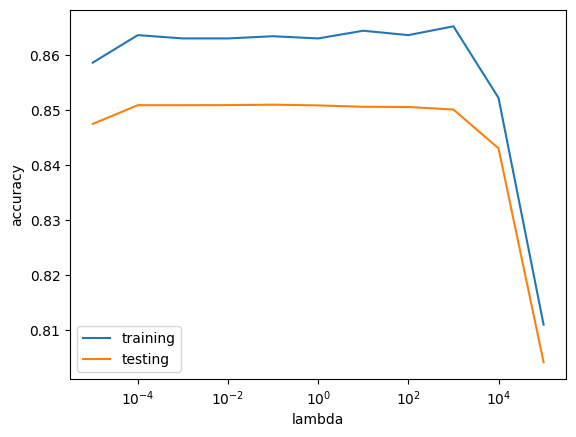

((tensor(0.8586),
  tensor(0.8636),
  tensor(0.8630),
  tensor(0.8630),
  tensor(0.8634),
  tensor(0.8630),
  tensor(0.8644),
  tensor(0.8636),
  tensor(0.8652),
  tensor(0.8522),
  tensor(0.8110)),
 (tensor(0.8475),
  tensor(0.8509),
  tensor(0.8509),
  tensor(0.8509),
  tensor(0.8510),
  tensor(0.8508),
  tensor(0.8506),
  tensor(0.8505),
  tensor(0.8501),
  tensor(0.8430),
  tensor(0.8042)))

In [4]:
import numpy as np

def plot_lambda_accuracies(X, T, lambdas=np.logspace(-5, 5, 11)):
    accuracies = []
    for lambd in lambdas:
        accuracies.append(test_ridge_regression(X, T, lambd))
    training, testing = zip(*accuracies)
    plt.plot(lambdas, training, label='training')
    plt.plot(lambdas, testing, label='testing')
    plt.xscale('log')
    plt.xlabel('lambda')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
    return training, testing

plot_lambda_accuracies(X, T)

**2. c) [1 mark]** The input we have used so far is not very realistic.  In real life, when we see written digits, they are under a wide range of lighting conditions. For this question, we change `X` by scaling it randomly and adding a random background brightness.

```
X = mnist.data.reshape((60000,28*28)).float()/255
X = X*(1-2*torch.rand(60000)[:,None]) + torch.rand(60000)[:,None]
```

To see what this looks like, here is how you can plot it:

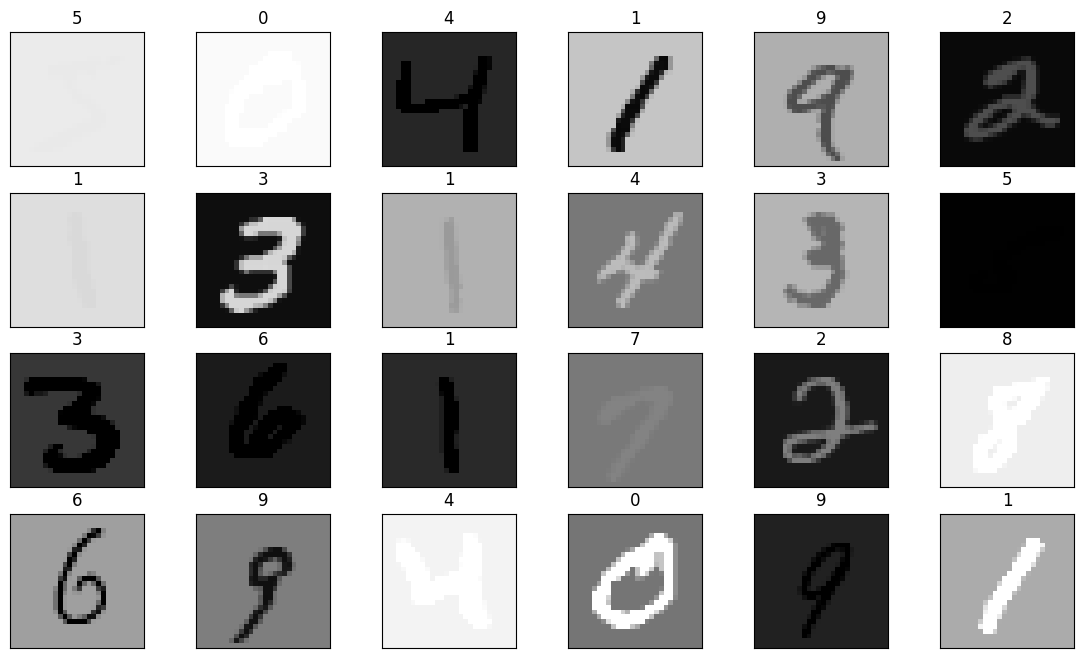

In [5]:
X = mnist.data.reshape((60000,28*28)).float()/255
X = X*(1-2*torch.rand(60000))[:,None] + torch.rand(60000)[:,None]

plt.figure(figsize=(14,8))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(X[i].reshape(28,28), vmin=0, vmax=1, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title(int(mnist.targets[i]))


- Generate the same plot as in 2b) but for this new dataset.  
- Is this a harder or easier task than with the original dataset?
  - Much harder. Not only did the algorithm fail to find an inverse for `lambd<=10e-4`, but it also has performed significantly worse in testing and training. The peak accuracy, with `lambd = 3.16`, was only 25.4 %. This is clearly a much harder problem that can't be meaning solved linearly.
- Is this new dataset more like the data at the retina or like the data in the ganglion cells?
  - It is more like the data at the retina, since the retina is exposed to a multitude of lighting conditions and contrasts.
- Is the original dataset more like the data at the retina or like the data in the ganglion cells?
  - The original dataset is more like the data in the ganglion cells, since the lighting has been normalized. Edges are preserved, but absolute values of brightness have been ignored.

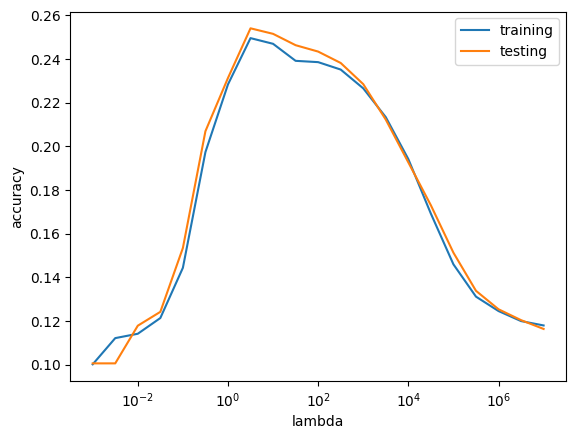

Best lambda: 3.162 (accuracy: 0.250)


In [6]:
lambdas = np.logspace(-3, 7, 21)
training, testing = plot_lambda_accuracies(X, T, lambdas)
best_lambda = lambdas[np.argmax(training)]
print(f'Best lambda: {best_lambda:.3f} (accuracy: {max(training):.3f})')

**2. d) [1 mark]** We can think of neurons in the visual system as transforming the data in various ways.  Given the dataset in 2c), neurons might be able to transform it to look more like the origin data.

Here are three data transformations that could be applied here:

Subtracting the Mean
```
X = X-torch.mean(X, axis=1)[:,None]
```

Absolute value
```
X = torch.abs(X)
```

Normalizing
```
X = X/torch.linalg.norm(X, axis=1)[:,None]
```

- Apply all three of them (in the order shown above) to the dataset and generate the same graph as in 2b) and 2c).
- How does the performance of the network compare to that of 2b) and 2c)?
- Do any of the three transformations above correspond to processing that occurs in the eye before the signal is sent to the rest of the brain?
- Given this result, why does the eye transform the data between raw rods & cones and the ganglion cells?

# TODO

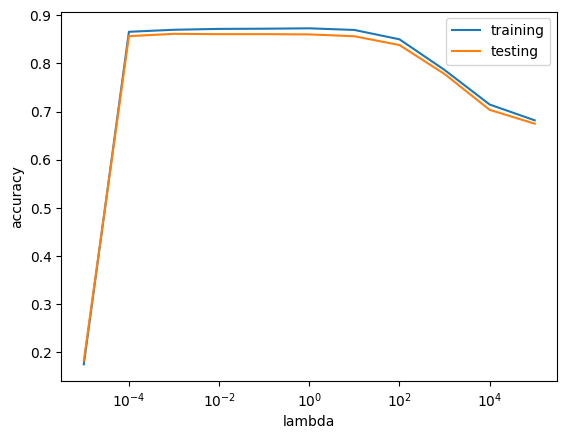

Best lambda: 0.316 (accuracy: 0.873)


In [7]:
X -= torch.mean(X, axis=1)[:,None]
X = torch.abs(X)
X /= torch.linalg.norm(X, axis=1)[:,None]

training, testing = plot_lambda_accuracies(X, T)
best_lambda = lambdas[np.argmax(training)]
print(f'Best lambda: {best_lambda:.3f} (accuracy: {max(training):.3f})')

# 3. Classifying Stimuli Using Backpropogation

Regression is restricted to learning the layer of weights that produces the final output.  If we want to also learn what features are most useful for producing that output, we need a more complex learning rule, and this is typically backpropogation.  Here we will classify the same data as in question 2, and we will build up different network structures to do so.

Backpropogation tends to work best when learning on a bunch of data at the same time (a "batch").  The following code will set up the same training and testing data as in question 2, but presented in randomized batches of 1000 at a time.

```python
mnist = torchvision.datasets.MNIST(root='.', download=True, transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000)), 
                                           batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000, 10000)), 
                                          batch_size=1000, shuffle=True)
```

To create a neural network, we need to define what the weights are we will learn and we need to define the computation that the network will perform.  Here is the definition of a simple network that has an input of 784 values (the MNIST inputs), which go to 50 "hidden"-layer neurons, and then to the output 10 neurons.  So the network will learn to transform the 784 inputs into 50 new representations, and from those 50 features it will learn weights to create an output of 10 values (our 10 categories).  This is known as a multi-layer perceptron, or a standard neural network with a single hidden layer.

```python
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # these will be learned
        self.fc1 = nn.Linear(784, 50)   # the weights from the input to the new learned features (hidden layer)
        self.fc2 = nn.Linear(50, 10)    # the weights from the hidden layer to the output

    def forward(self, x):
        # the processing the network will do
        x = x.view(-1, 784)             # flatten the input from 28x28 to 784 values
        x = F.relu(self.fc1(x))         # apply the first set of weights, then apply the ReLU neuron model
        x = self.fc2(x)                 # apply the second set of weights
        return F.log_softmax(x)         # apply a softmax function as we just want one large output indicating category
    
network = Net()
```

In [8]:
import torch.nn.functional as F
from torch import nn
from torch import optim

mnist = torchvision.datasets.MNIST(root='.', download=True, transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000)), 
                                           batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000, 10000)), 
                                          batch_size=1000, shuffle=True)

class Net(nn.Module):
    def __init__(self, hidden=50):
        super(Net, self).__init__()
        # these will be learned
        self.fc1 = nn.Linear(784, hidden)   # the weights from the input to the new learned features (hidden layer)
        self.fc2 = nn.Linear(hidden, 10)    # the weights from the hidden layer to the output

    def forward(self, x):
        # the processing the network will do
        x = x.view(-1, 784)             # flatten the input from 28x28 to 784 values
        x = F.relu(self.fc1(x))         # apply the first set of weights, then apply the ReLU neuron model
        x = self.fc2(x)                 # apply the second set of weights
        return F.log_softmax(x, dim=0)  # apply a softmax function as we just want one large output indicating category

network = Net()

Finally, we need to train our model.  When training, it is useful to keep track of how well the model is doing on the testing data.  Since testing the network takes time, we don't necessarily want to do it all the time.  Instead, the following code trains the network 10 times, and then records how well the network does on the training data and on the testing data.

In [9]:
# create the learning rule
optimizer = optim.SGD(network.parameters(), 
                      lr=0.1,   # learning rate
                      momentum=0.5)

# variables to keep track of the training and testing accuracy
accuracy_train = []
accuracy_test = []

def continue_training(run_test=True):
    network.train()      # configure the network for training
    for i in range(10):  # train the network 10 times
        correct = 0
        for data, target in train_loader:       # working in batchs of 1000
            optimizer.zero_grad()               # initialize the learning system
            output = network(data)              # feed in the data 
            loss = F.nll_loss(output, target)   # compute how wrong the output is
            loss.backward()                     # change the weights to reduce error
            optimizer.step()                    # update the learning rule
            
            pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
            correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs
    # update the list of training accuracy values
    score = float(correct/len(train_loader.dataset))
    accuracy_train.append(score)
    print('Iteration', len(accuracy_train), 'Training accuracy:', score)

    if run_test:
        # update the list of testing accuracy values
        accuracy_test.append(test_net())
        print('Iteration', len(accuracy_test), 'Testing accuracy:', accuracy_test[-1])


def test_net():
    correct = 0
    network.eval()
    for data, target in test_loader:    # go through the test data once (in groups of 1000)
        output = network(data)                               # feed in the data
        pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
        correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs
    score = float(correct/len(test_loader.dataset))
    return score


Given the above code, you can train your network 10 times by doing

```python
for i in range(10):
    continue_training()
```

If you want to continue training even more, you can just run that `for` loop again.

To plot the final accuracy results, you can use

```python
plt.figure(figsize=(12,4))
plt.plot(accuracy_train, label='training')
plt.plot(accuracy_test, label='testing')
plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.show()
```

**3. a) [1 mark]** Run the model above for 10 iterations (i.e. call `continue_training` 10 times).

- Plot the training and testing accuracy.  
- Is this model better or worse than the best models developed in question 2?

This model has better accuracy on the training and testing datasets.

Iteration 1 Training accuracy: 0.8651999831199646
Iteration 1 Testing accuracy: 0.8492000102996826
Iteration 2 Training accuracy: 0.8984000086784363
Iteration 2 Testing accuracy: 0.8804000020027161
Iteration 3 Training accuracy: 0.9151999950408936
Iteration 3 Testing accuracy: 0.8898000121116638
Iteration 4 Training accuracy: 0.9232000112533569
Iteration 4 Testing accuracy: 0.8956000208854675
Iteration 5 Training accuracy: 0.9273999929428101
Iteration 5 Testing accuracy: 0.9007999897003174
Iteration 6 Training accuracy: 0.9345999956130981
Iteration 6 Testing accuracy: 0.90420001745224
Iteration 7 Training accuracy: 0.9391999840736389
Iteration 7 Testing accuracy: 0.9071999788284302
Iteration 8 Training accuracy: 0.9419999718666077
Iteration 8 Testing accuracy: 0.9107999801635742
Iteration 9 Training accuracy: 0.9458000063896179
Iteration 9 Testing accuracy: 0.9133999943733215
Iteration 10 Training accuracy: 0.9521999955177307
Iteration 10 Testing accuracy: 0.9160000085830688


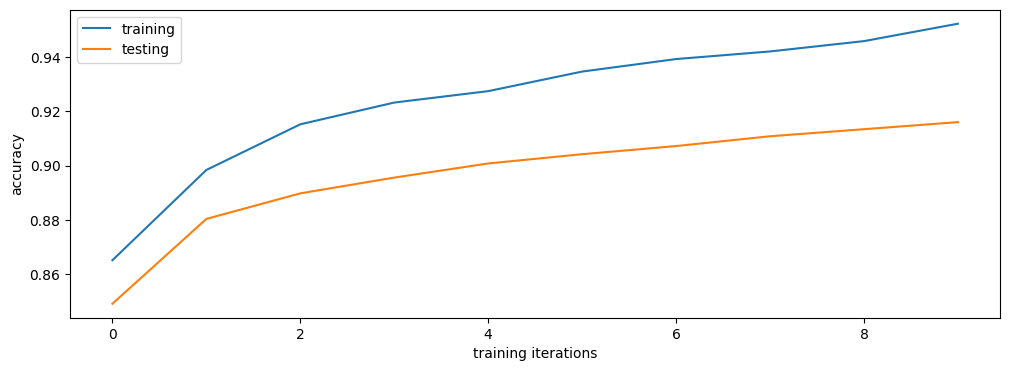

In [10]:
for i in range(10):
    continue_training()

plt.figure(figsize=(12,4))
plt.plot(accuracy_train, label='training')
plt.plot(accuracy_test, label='testing')
plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.show()

**3. b) [1 mark]** Repeat question 3a five times.  This does not mean to run a single model for 50 iterations.  Rather, you need to reset the model and train it again.  The easiest way to do this is to recreate the network and the optimizer like this:

```python
network = Net()
optimizer = optim.SGD(network.parameters(), 
                      lr=0.1,
                      momentum=0.5)
```

- Make a plot showing the 5 different training accuracies and 5 different testing accuracies
- Also show the average training and testing accuracy on the plot.
- Each of the 5 models should show slightly different accuracies.  Why is this the case?
This is because there is intentional randomization involved in the initialization and training of the network.


In [11]:
accuracy_train = []
accuracy_test = []

attempts = 5
epochs = 10

for i in range(attempts):
    print(f"Starting run {i+1}...")
    network = Net()
    optimizer = optim.SGD(network.parameters(), lr=0.1, momentum=0.5)
    for _ in range(epochs):
        continue_training()

assert len(accuracy_train) == attempts*epochs
assert len(accuracy_test) == attempts*epochs

Starting run 1...
Iteration 1 Training accuracy: 0.8622000217437744
Iteration 1 Testing accuracy: 0.843999981880188
Iteration 2 Training accuracy: 0.8989999890327454
Iteration 2 Testing accuracy: 0.8763999938964844
Iteration 3 Training accuracy: 0.9132000207901001
Iteration 3 Testing accuracy: 0.8877999782562256
Iteration 4 Training accuracy: 0.9218000173568726
Iteration 4 Testing accuracy: 0.895799994468689
Iteration 5 Training accuracy: 0.9297999739646912
Iteration 5 Testing accuracy: 0.9003999829292297
Iteration 6 Training accuracy: 0.9355999827384949
Iteration 6 Testing accuracy: 0.9028000235557556
Iteration 7 Training accuracy: 0.9394000172615051
Iteration 7 Testing accuracy: 0.9052000045776367
Iteration 8 Training accuracy: 0.9434000253677368
Iteration 8 Testing accuracy: 0.9118000268936157
Iteration 9 Training accuracy: 0.948199987411499
Iteration 9 Testing accuracy: 0.9139999747276306
Iteration 10 Training accuracy: 0.9520000219345093
Iteration 10 Testing accuracy: 0.9165999889

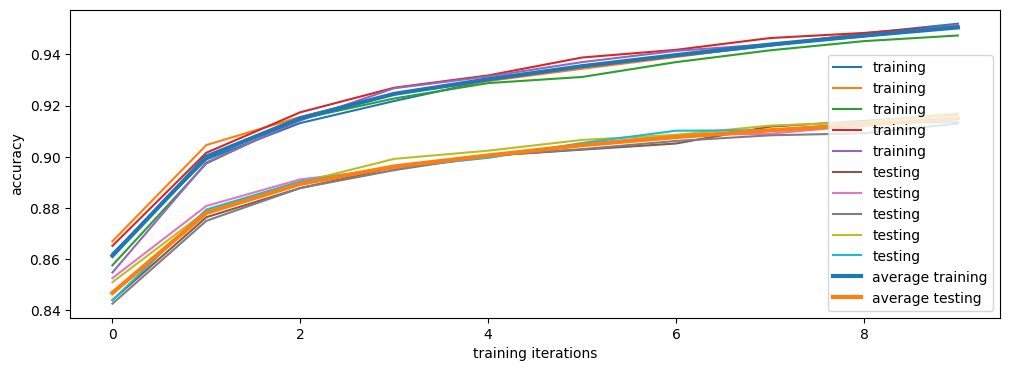

In [12]:
train_results = np.array(accuracy_train).reshape((attempts, epochs)).T
test_results = np.array(accuracy_test).reshape((attempts, epochs)).T

average_train = np.mean(train_results, axis=1)
average_test = np.mean(test_results, axis=1)

plt.figure(figsize=(12,4))
plt.plot(train_results, label='training')
plt.plot(test_results, label='testing')
plt.plot(average_train, label='average training', linewidth=3)
plt.plot(average_test, label='average testing', linewidth=3)
plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.show()

**3. c) [1 mark]** Repeat question 3b varying the number of neurons in the hidden layer of the network.  The current value is 50.  Try it with 5, 10, 20, 50, and 100 neurons.  For each number of neurons, repeat five times and take the average (like in question 3b).  

- Plot the final testing accuracy on the y-axis and the number of neurons on the x-axis.  Note that to speed things up you can remove the testing computation from continue_training until the very end, since we only need the final testing score.


In [13]:
neuron_dims = [5, 10, 20, 50, 100]
attempts = 5
epochs = 10

accuracy_train = [] # Reset the dumb global variables
accuracy_test = []

for neuron_dim in neuron_dims:
    for i in range(attempts):
        print(f"Starting run {i+1}...")
        network = Net(hidden=neuron_dim)
        optimizer = optim.SGD(network.parameters(), lr=0.1, momentum=0.5)
        for _ in range(epochs):
            continue_training(run_test=False)
        accuracy_test.append(test_net())

assert len(accuracy_train) == len(neuron_dims)*attempts*epochs

Starting run 1...
Iteration 1 Training accuracy: 0.7447999715805054
Iteration 2 Training accuracy: 0.8374000191688538
Iteration 3 Training accuracy: 0.8583999872207642
Iteration 4 Training accuracy: 0.8686000108718872
Iteration 5 Training accuracy: 0.8745999932289124
Iteration 6 Training accuracy: 0.8808000087738037
Iteration 7 Training accuracy: 0.8826000094413757
Iteration 8 Training accuracy: 0.8830000162124634
Iteration 9 Training accuracy: 0.8895999789237976
Iteration 10 Training accuracy: 0.8913999795913696
Starting run 2...
Iteration 11 Training accuracy: 0.5558000206947327
Iteration 12 Training accuracy: 0.7710000276565552
Iteration 13 Training accuracy: 0.8202000260353088
Iteration 14 Training accuracy: 0.8456000089645386
Iteration 15 Training accuracy: 0.8539999723434448
Iteration 16 Training accuracy: 0.8574000000953674
Iteration 17 Training accuracy: 0.8654000163078308
Iteration 18 Training accuracy: 0.8691999912261963
Iteration 19 Training accuracy: 0.8740000128746033
Iter

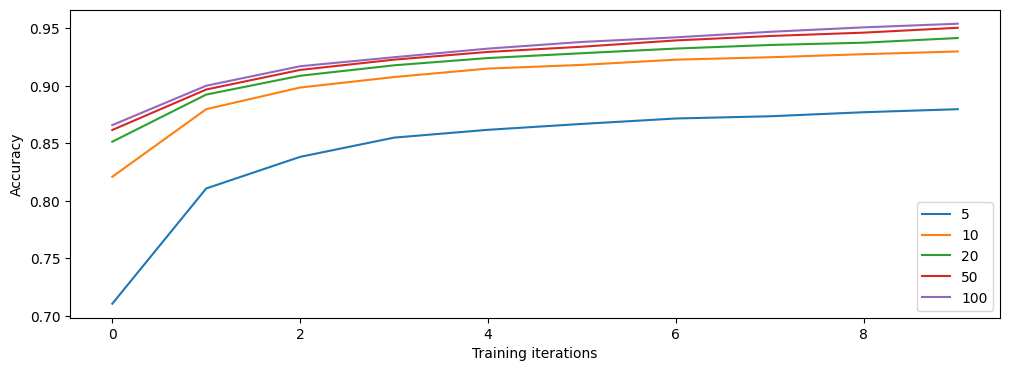

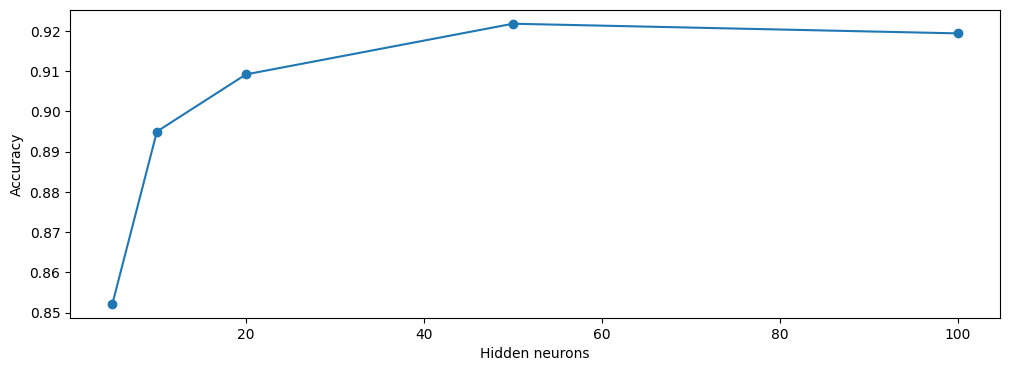

In [24]:
train_results2 = np.array(accuracy_train).reshape((len(neuron_dims), attempts, epochs)).T
test_results2 = np.array(accuracy_test).reshape((len(neuron_dims), attempts)).T

average_train2 = np.mean(train_results2, axis=1)
average_test2 = np.mean(test_results2, axis=1)

plt.figure(figsize=(12,4))
plt.plot(average_train2, label=neuron_dims)
plt.legend()
plt.xlabel('Training iterations')
plt.ylabel('Accuracy')
plt.show()

plt.figure(figsize=(12,4))
plt.plot(neuron_dims, average_test2, '-o')
plt.xlabel('Hidden neurons')
plt.ylabel('Accuracy')
plt.show()

**3. d) [2 marks]** Now we will add a convolution layer to our network.  The following network adds two convolution layers before two normal neural network layers.

```python
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=5)  # set the size of the convolution to 5x5, and have 12 of them
        self.conv2 = nn.Conv2d(12, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # make sure to do max pooling after the convolution layers
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)
```

The following code can be used to plot the learned features in the first layer:
```python
plt.figure(figsize=(12,5))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(network.conv1.weight[i][0].detach().numpy(), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
plt.show()
```

- Train the model through 40 iterations and generate a plot of training and testing accuracy over time.
- Does this perform better or worse than the previous models in this assignment?
- What advantages and disadvantages do you see with this approach (in comparison to the previous parts of the assignment)?
- Plot the features learned by the first convolution layer.  How do they compare to real features detected in the V1 area of the brain?

C:\Users\dan\AppData\Local\Temp\ipykernel_18620\2746418287.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Iteration 1 Training accuracy: 0.38499999046325684
Iteration 1 Testing accuracy: 0.49059998989105225
Iteration 2 Training accuracy: 0.9165999889373779
Iteration 2 Testing accuracy: 0.9047999978065491
Iteration 3 Training accuracy: 0.951200008392334
Iteration 3 Testing accuracy: 0.9296000003814697
Iteration 4 Training accuracy: 0.9639999866485596
Iteration 4 Testing accuracy: 0.9401999711990356
Iteration 5 Training accuracy: 0.9696000218391418
Iteration 5 Testing accuracy: 0.9470000267028809
Iteration 6 Training accuracy: 0.9765999913215637
Iteration 6 Testing accuracy: 0.9526000022888184
Iteration 7 Training accuracy: 0.9847999811172485
Iteration 7 Testing accuracy: 0.9531999826431274
Iteration 8 Training accuracy: 0.9814000129699707
Iteration 8 Testing accuracy: 0.9485999941825867
Iteration 9 Training accuracy: 0.8259999752044678
Iteration 9 Testing accuracy: 0.8615999817848206
Iteration 10 Training accuracy: 0.9621999859809875
Iteration 10 Testing accuracy: 0.9326000213623047
Iterati

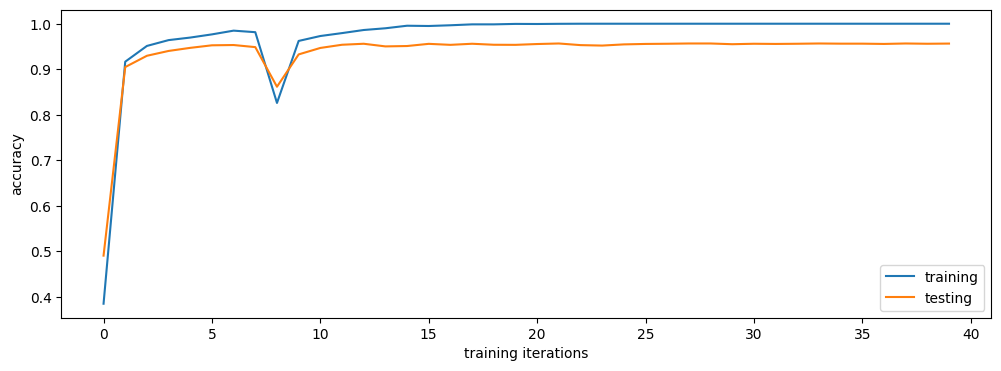

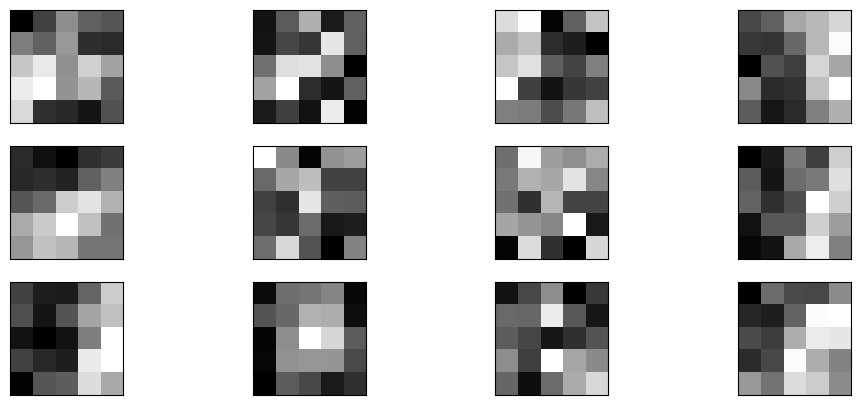

In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=5)  # set the size of the convolution to 5x5, and have 12 of them
        self.conv2 = nn.Conv2d(12, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # make sure to do max pooling after the convolution layers
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

accuracy_test = []
accuracy_train = []
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.1, momentum=0.5)

for i in range(40):
    continue_training()

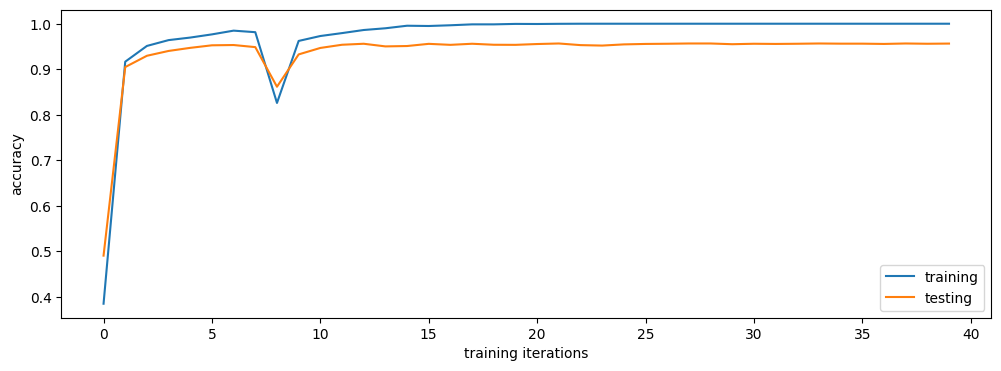

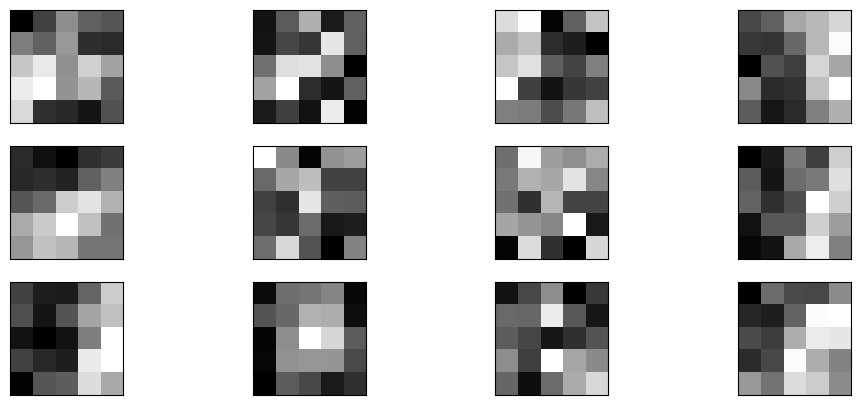

In [28]:
plt.figure(figsize=(12,4))
plt.plot(accuracy_train, label='training')
plt.plot(accuracy_test, label='testing')
plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.show()

plt.figure(figsize=(12,5))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(network.conv1.weight[i][0].detach().numpy(), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
plt.show()

**BONUS [1 mark]** Try to improve the neural network.  You want to get the best testing accuracy you can.  Try at least two different approaches and report your results.